In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import HeNormal
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate only a fraction of GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
    except RuntimeError as e:
        print(e)


In [3]:
ckplus_dir = '/kaggle/input/ckplus/CK+48' 

# Define the list of emotion labels used in CK+
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Initialize empty lists to store images and labels
images = []
labels = []

# Load and preprocess the data
for emotion_label in emotion_labels:
    emotion_dir = os.path.join(ckplus_dir, emotion_label)
    for img_filename in os.listdir(emotion_dir):
        img_path = os.path.join(emotion_dir, img_filename)
        
        # Load the image using OpenCV and resize it to a fixed size (e.g., 48x48)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        
        # Normalize the pixel values to a range of [0, 1]
        img = img / 255.0
        
        # Append the image and its corresponding label to the lists
        images.append(img)
        labels.append(emotion_labels.index(emotion_label))

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the datasets (optional)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (686, 48, 48)
Validation data shape: (147, 48, 48)
Testing data shape: (148, 48, 48)


Emotion: anger


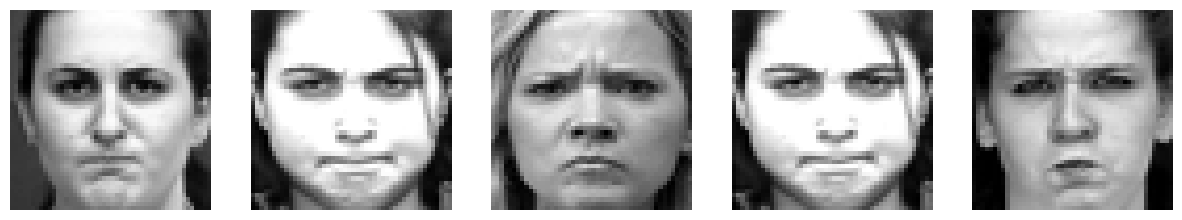

Emotion: contempt


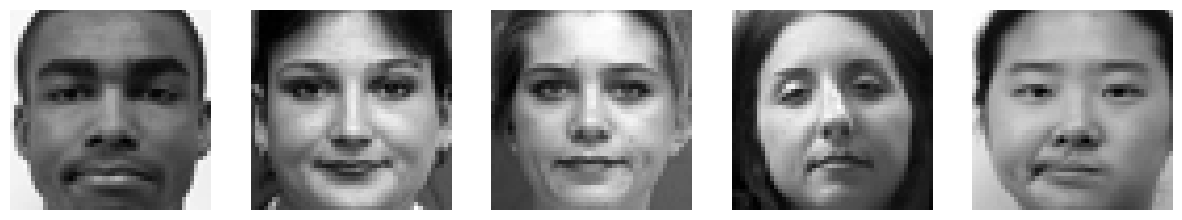

Emotion: disgust


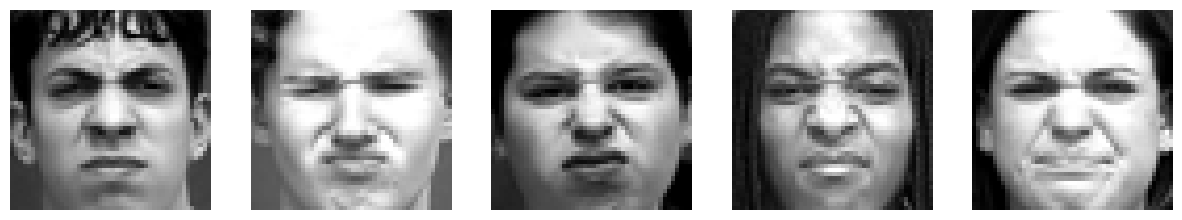

Emotion: fear


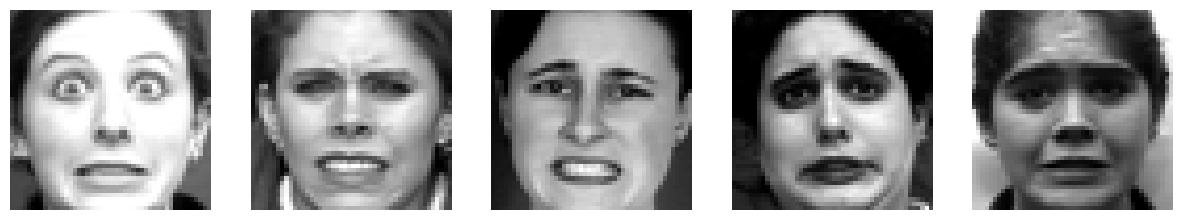

Emotion: happy


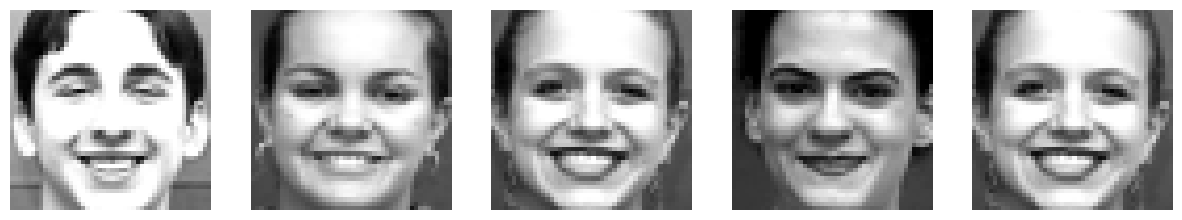

Emotion: sadness


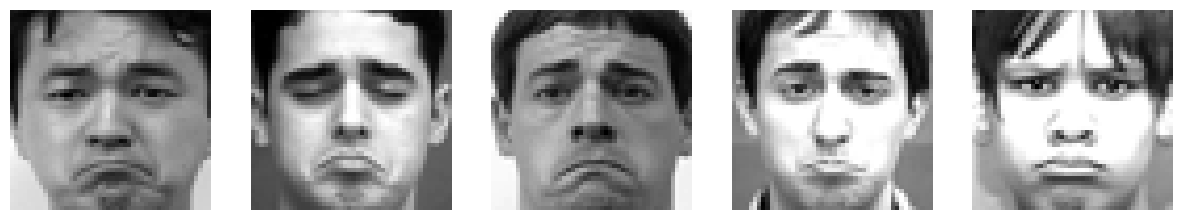

Emotion: surprise


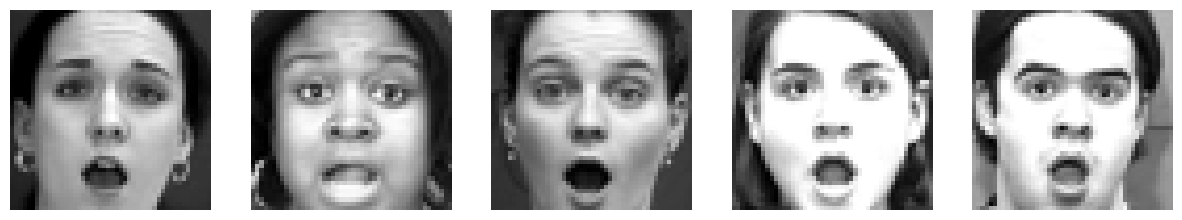

In [5]:
num_images_per_emotion = 5

for emotion_label in emotion_labels:
    emotion_dir = os.path.join(ckplus_dir, emotion_label)
    image_files = [os.path.join(emotion_dir, filename) for filename in os.listdir(emotion_dir) if os.path.isfile(os.path.join(emotion_dir, filename))]

    if len(image_files) >= num_images_per_emotion:
        random_images = random.sample(image_files, num_images_per_emotion)

        print(f"Emotion: {emotion_label}")

        plt.figure(figsize=(15, 5))

        for i, image_path in enumerate(random_images):
            plt.subplot(1, num_images_per_emotion, i + 1)
            img = mpimg.imread(image_path)
            plt.imshow(img, cmap='gray') 
            plt.axis('off')

        plt.show()

In [6]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,            # Normalize pixel values to the range [0, 1]
    rotation_range=20,              # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,          # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,         # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,                # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,                 # Randomly zoom images by up to 20%
    horizontal_flip=True,           # Randomly flip images horizontally
    fill_mode='nearest',            # Fill in newly created pixels after rotation or shifting
    validation_split=0.2,
)

In [7]:
# Load training data
train_generator = datagen.flow_from_directory(
    ckplus_dir,
    target_size=(48, 48),   # Resize images to a common size (you can adjust this)
    batch_size=32,
    class_mode='categorical',  # For multiple classes
    subset='training'          # Use 'training' subset
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    ckplus_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Use 'validation' subset
)

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [8]:
# model = Sequential([
#     # First Convolutional Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3), kernel_initializer=HeNormal()),
#     MaxPooling2D((2, 2)),

#     # Second Convolutional Layer
#     Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
#     MaxPooling2D((2, 2)),

#     # Third Convolutional Layer
#     Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
#     MaxPooling2D((2, 2)),

#     # Flatten the output for the fully connected layers
#     Flatten(),

#     # Fully Connected Layers
#     Dense(128, activation='relu', kernel_initializer=HeNormal()),
#     Dropout(0.5),  # Dropout layer to reduce overfitting
#     Dense(7, activation='softmax', kernel_initializer=HeNormal())  # Output layer with 7 classes (emotions)
# ])

model = Sequential([
    Conv2D(6, (5, 5), input_shape=(48, 48, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [9]:
# new_adam = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     weight_decay=None,
#     clipnorm=None,
#     clipvalue=None,
#     global_clipnorm=None,
#     use_ema=False,
#     ema_momentum=0.99,
#     ema_overwrite_frequency=None,
#     jit_compile=True,
#     name='Adam'
# )

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Print model summary (optional)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9

In [11]:
# Set the number of epochs and batch size
epochs = 100
batch_size = 32

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Reduce learning rate by half
    patience=3,           # Number of epochs with no improvement after which the learning rate will be reduced
    verbose=1
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best weights when stopped
)

In [12]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping,lr_scheduler]  
)

Epoch 1/100
24/24 [==============================] - 16s 241ms/step - loss: 1.8479 - accuracy: 0.2396 - val_loss: 1.8279 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 2s 87ms/step - loss: 1.8285 - accuracy: 0.2659 - val_loss: 1.8027 - val_accuracy: 0.2552 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 2s 75ms/step - loss: 1.7889 - accuracy: 0.2884 - val_loss: 1.7409 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 1.6862 - accuracy: 0.3228 - val_loss: 1.6486 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 2s 85ms/step - loss: 1.6012 - accuracy: 0.3611 - val_loss: 1.5998 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 2s 73ms/step - loss: 1.5362 - accuracy: 0.3704 - val_loss: 1.5086 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 2s 74ms/step - 

In [ ]:
history.history.

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [22]:
history.history

{'loss': [1.8479350805282593,
  1.8285094499588013,
  1.7889149188995361,
  1.686237096786499,
  1.6012029647827148,
  1.5362335443496704,
  1.4696491956710815,
  1.4717949628829956,
  1.4471662044525146,
  1.412288784980774,
  1.3474702835083008,
  1.3341339826583862,
  1.3300089836120605,
  1.33096444606781,
  1.275482416152954,
  1.2379086017608643,
  1.2589699029922485,
  1.2033113241195679,
  1.189229130744934,
  1.1829150915145874,
  1.1409047842025757,
  1.092292070388794,
  1.057154893875122,
  1.1032578945159912,
  1.0200958251953125,
  0.9989510178565979,
  0.9675444960594177,
  0.9555488228797913,
  0.9633144736289978,
  0.9303326606750488,
  0.8935330510139465,
  0.8670103549957275,
  0.9082738757133484,
  0.8703349828720093,
  0.8573201298713684,
  0.817707359790802,
  0.7846980094909668,
  0.7917219400405884,
  0.8237217664718628,
  0.7984511852264404,
  0.7650162577629089,
  0.7666186690330505],
 'accuracy': [0.2395833283662796,
  0.2658730149269104,
  0.2883597910404205

In [24]:
# Save the trained model
model.save('ck_plus_emotion_model.h5')

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

7/7 [==============================] - 1s 158ms/step - loss: 0.8623 - accuracy: 0.7098
Test accuracy: 70.98%


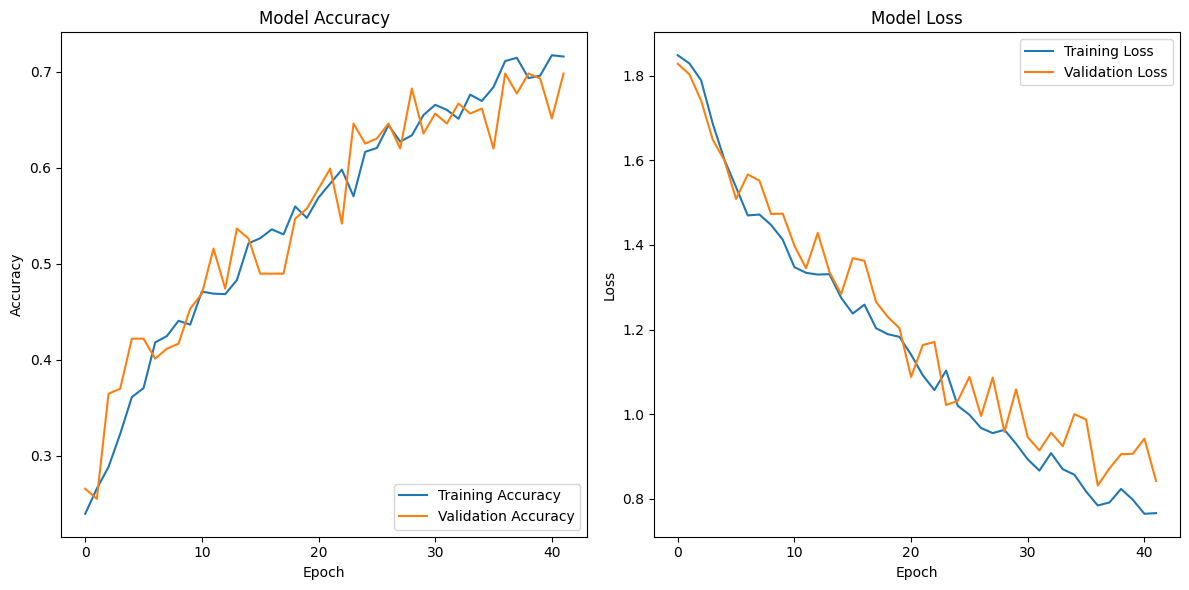

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


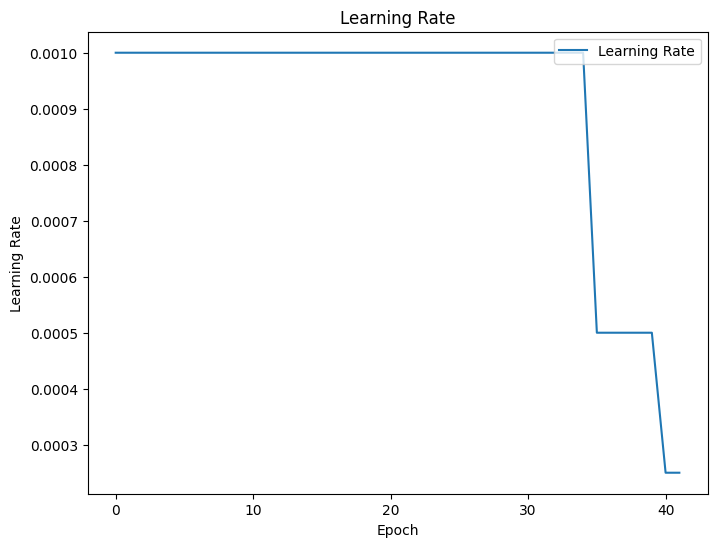

In [19]:
# Plot learning rate values
plt.figure(figsize=(8, 6))
plt.plot(history.history['lr'], label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend(loc='upper right')
plt.show()